In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.optimizers import Adam
from tensorflow.keras.layers import LSTM

In [2]:
# Loading the dataset from the 'train' directory

batch_size = 512
seed = 1337 # Keep the seed same for both 'train' & 'validation' to avoid overlap

train_ds = keras.preprocessing.text_dataset_from_directory(
    "../input/positionalembedding/hw2-ycbs-273-intro-to-prac-ml (1)/train", 
    batch_size=batch_size,
    label_mode='int',
    validation_split=0.2,
    subset='training',
    seed=seed)

val_ds = keras.preprocessing.text_dataset_from_directory(
    "../input/positionalembedding/hw2-ycbs-273-intro-to-prac-ml (1)/train",
    batch_size=batch_size,
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=seed)

text_only_train_ds = train_ds.map(lambda x, y: x)

Found 120000 files belonging to 4 classes.
Using 96000 files for training.
Found 120000 files belonging to 4 classes.
Using 24000 files for validation.


In [3]:
from tensorflow.keras import layers

max_length = 80
max_tokens = 20000
text_vectorization = TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y))
int_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y))
# int_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y))



In [4]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-08-16 15:32:57--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-08-16 15:32:57--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-08-16 15:32:57--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [5]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [6]:
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [7]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

In [8]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)


In [9]:
#setting compile and learning rate
adam = Adam(lr = 3e-4)
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         2000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                34048     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 260       
Total params: 2,034,308
Trainable params: 34,308
Non-trainable params: 2,000,000
_________________________________________________________________


In [10]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience = 5,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="glove_embeddings_sequence_model.keras",
        monitor="val_accuracy",
        save_best_only=True,
    )
]

In [11]:
model_history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=30, callbacks=callbacks_list)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_val_ds)[1]:.3f}")

Epoch 1/30
188/188 [==============================] - 307s 2s/step - loss: 0.7848 - accuracy: 0.6876 - val_loss: 0.3457 - val_accuracy: 0.8826
Epoch 2/30
188/188 [==============================] - 153s 787ms/step - loss: 0.3483 - accuracy: 0.8840 - val_loss: 0.3194 - val_accuracy: 0.8921
Epoch 3/30
188/188 [==============================] - 171s 882ms/step - loss: 0.3195 - accuracy: 0.8911 - val_loss: 0.3092 - val_accuracy: 0.8949
Epoch 4/30
188/188 [==============================] - 167s 861ms/step - loss: 0.3030 - accuracy: 0.8964 - val_loss: 0.2988 - val_accuracy: 0.8979
Epoch 5/30
188/188 [==============================] - 168s 868ms/step - loss: 0.2932 - accuracy: 0.8993 - val_loss: 0.2923 - val_accuracy: 0.9002
Epoch 6/30
188/188 [==============================] - 211s 1s/step - loss: 0.2840 - accuracy: 0.9020 - val_loss: 0.2842 - val_accuracy: 0.9027
Epoch 7/30
188/188 [==============================] - 169s 871ms/step - loss: 0.2749 - accuracy: 0.9057 - val_loss: 0.2774 - val_a

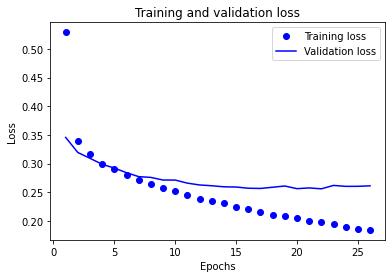

In [18]:
import matplotlib.pyplot as plt
#draw plot for visualization
history_dict = model_history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.show()

In [13]:
# Using the trained model to make prediction on unseen (test) data
# Here we use the 'adapted' text_vectorization layer and include it as part of a prediction_model

prediction_model = tf.keras.Sequential(
    [text_vectorization, model])

prediction_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])

# Test it with `val_ds`, which yields raw strings
loss, accuracy = prediction_model.evaluate(val_ds)
print("Accuracy: {:2.2%}".format(accuracy))

47/47 [==============================] - 19s 228ms/step - loss: 0.2555 - accuracy: 0.9167
Accuracy: 91.40%


In [14]:
# Read the test data in the form of a dataframe

df_test_data = pd.read_csv('../input/positionalembedding/data_test_df.csv')
inputs = df_test_data['data']

In [15]:
# Make sure you use the 'prediction_model' and not the trained 'model' alone
# If you use the 'model' object, you will run int error as the data is still in the 'text' format and needs vectorization

predicted_scores = prediction_model.predict(inputs)
predicted_scores[0:5]

array([[6.97190315e-03, 1.35088005e-04, 9.90792036e-01, 2.10095593e-03],
       [9.71211307e-03, 1.11518726e-04, 2.14499072e-03, 9.88031387e-01],
       [2.86449189e-03, 2.50853191e-04, 3.14327739e-02, 9.65451777e-01],
       [1.83245689e-02, 9.01818834e-03, 8.27342942e-02, 8.89922857e-01],
       [6.71990886e-02, 1.02736034e-04, 3.82313807e-03, 9.28875089e-01]],
      dtype=float32)

In [16]:
# populating the dataframe to make a submission on Kaggle

df_predictions = pd.DataFrame(predicted_scores, columns=['solution_' + str(i+1) for i in range(4)])
df_predictions.index.rename('Id', inplace=True)

df_predictions.head(30)

,solution_1,solution_2,solution_3,solution_4
Id,,,,
0,0.006972,0.000135,0.990792,0.002101
1,0.009712,0.000112,0.002145,0.988031
2,0.002864,0.000251,0.031433,0.965452
3,0.018325,0.009018,0.082734,0.889923
4,0.067199,0.000103,0.003823,0.928875
5,0.009337,0.000046,0.003150,0.987467
6,0.009304,0.000041,0.000969,0.989686
7,0.002515,0.000856,0.052613,0.944017
8,0.009529,0.000158,0.111156,0.879157


In [17]:
# If using colab, then download this and submit on Kaggle

df_predictions.to_csv('df_predictions_end0.csv')